## Exploring With Sales Data

In [165]:
import pandas as pd

data = pd.read_csv('../../assets/dataset/rossmann.csv', skipinitialspace=True, low_memory=False)

Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [166]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month

In [179]:
store1_data = data[data.Store == 1]
print store1_data.head(35)
store1_dataOpen = store1_data[store1_data.Open == 1]

            Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-30      1          4   5020        546     1      1            0   
2015-07-29      1          3   4782        523     1      1            0   
2015-07-28      1          2   5011        560     1      1            0   
2015-07-27      1          1   6102        612     1      1            0   
2015-07-26      1          7      0          0     0      0            0   
2015-07-25      1          6   4364        500     1      0            0   
2015-07-24      1          5   3706        459     1      0            0   
2015-07-23      1          4   3769        503     1      0            0   
2015-07-22      1          3   3464        463     1      0            0   
2015-07-21      1          2   3558        469     1      0            0   
2015-07-20  

### Data Exploration and MINEing

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days. On state holidays the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

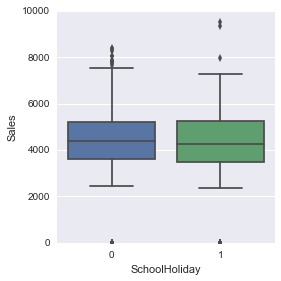

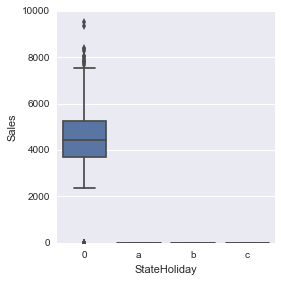

In [124]:
import seaborn as sb
%matplotlib inline

sb.factorplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

sb.factorplot(
    x='StateHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

> Check: See if there is a difference affecting sales on promotion days.

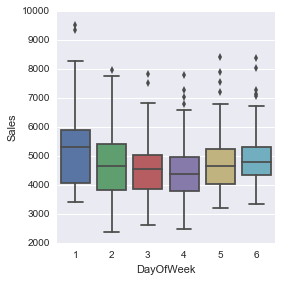

In [142]:
sb.factorplot(
    x='DayOfWeek',
    y='Sales',
    data=store1_data[store1_data.Open == 1],
    kind='box',
    
)

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

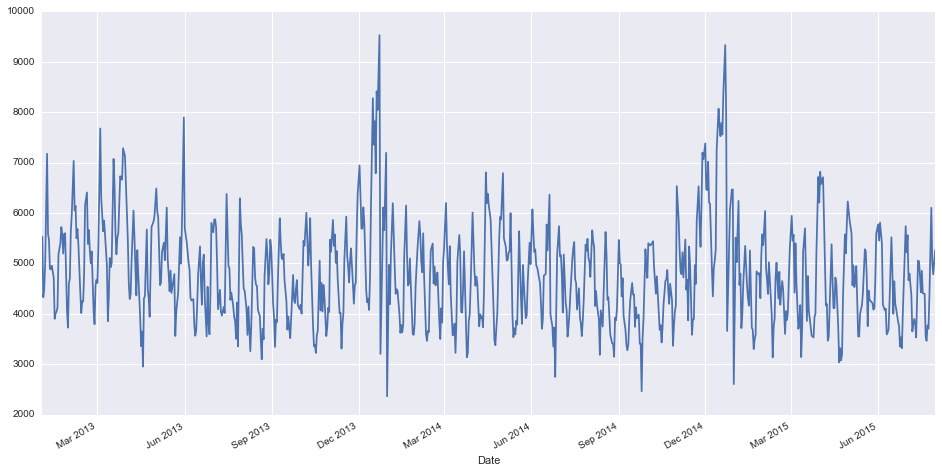

In [146]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]
store1_open_data['Sales'].plot(figsize=(16,8))

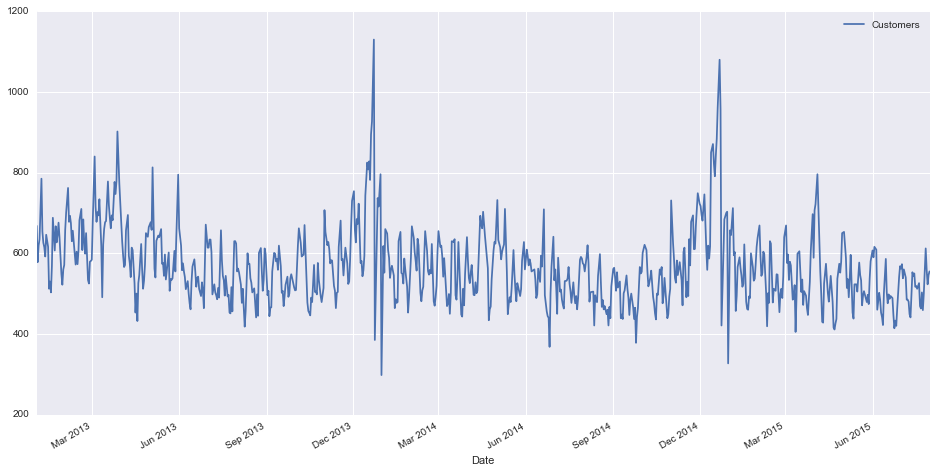

In [111]:
store1_open_data[['Customers']].plot(figsize=(16,8))

In pandas we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

### Data REFINING Using Time Series Statistics

### Autocorrelation

In [149]:
for x in range(0,13):
    print data['Sales'].resample('M', how='mean').autocorr(lag=x)

1.0
0.138085487392
-0.164724653806
0.0484652935818
0.282131354781
0.150984667593
-0.107547494427
0.179184786855
0.134208376846
0.206431834503
-0.201591388222
-0.018619173936
0.807279701645


### Rolling Averages

In [113]:
data[['Sales']].resample('M', how=['median', 'mean']).head()

Sales             
            median         mean
Date                           
2013-01-31  5194.0  5211.555578
2013-02-28  5421.5  5494.371397
2013-03-31  5844.0  5820.349168
2013-04-30  5464.0  5483.749836
2013-05-31  5585.0  5364.127383

In [153]:
pd.rolling_mean(data[['Sales']], window=5, center=True, freq='D').head()

,Sales
Date,
2013-01-01,NaN
2013-01-02,NaN
2013-01-03,4661.079513
2013-01-04,4669.434978
2013-01-05,5364.864395


`rolling_mean` (as well as `rolling_median`) takes these important parameters:
    - the first is the series to aggregate
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date
    - `freq` is on what level to roll-up the averages to (as used in `resample`). Either `D` for day, `M` for month or `A` for year, etc.

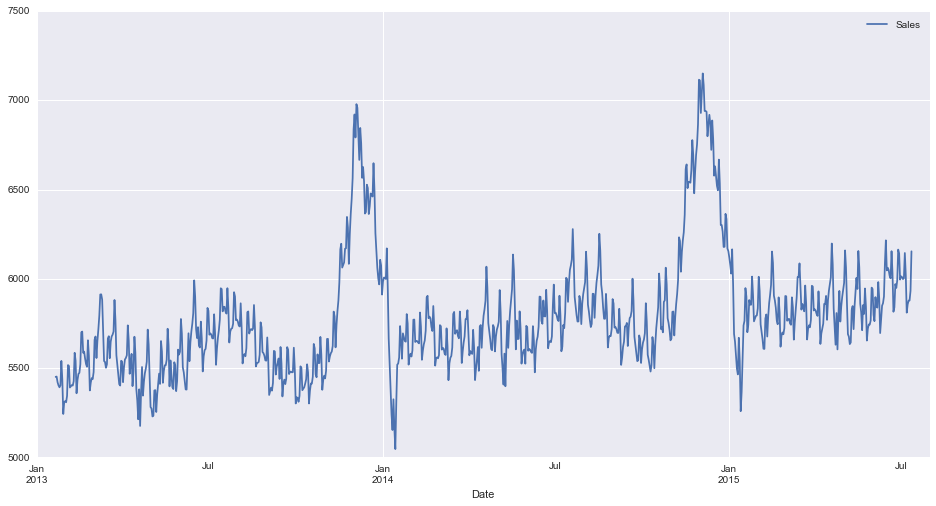

In [164]:
pd.rolling_mean(data[['Sales']], window=40, center=True, freq='D').plot(figsize=(16,8))

In [175]:
store1_open_data['Sales'].diff(periods=4).head(20)

Date
2015-07-31     NaN
2015-07-30     NaN
2015-07-29     NaN
2015-07-28     NaN
2015-07-27     839
2015-07-25    -656
2015-07-24   -1076
2015-07-23   -1242
2015-07-22   -2638
2015-07-21    -806
2015-07-20     689
2015-07-18     637
2015-07-17    1388
2015-07-16     869
2015-07-15     372
2015-07-14     636
2015-07-13     202
2015-07-11    -897
2015-07-10    -959
2015-07-09   -1145
Name: Sales, dtype: float64

### Pandas expanding functions with sales


In [176]:
# computes the average sales, from the first date _until_ the date specified.
pd.expanding_mean(data['Sales'], freq='d').head(10)

Date
2013-01-01      87.284560
2013-01-02    3160.157527
2013-01-03    4004.475720
2013-01-04    4491.911499
2013-01-05    4661.079513
2013-01-06    3905.743241
2013-01-07    4734.948147
2013-01-08    5123.958216
2013-01-09    5326.587971
2013-01-10    5489.129622
Freq: D, Name: Sales, dtype: float64

Distribution of sales by month and comparison of the effect of promotions

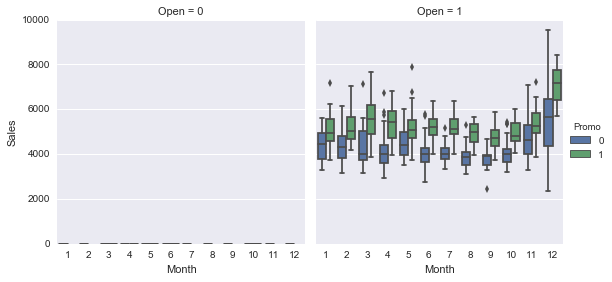

In [118]:
sb.factorplot(
    col='Open',
    hue='Promo',
    x='Month',
    y='Sales',
    data=store1_data, 
    kind='box'
)

In [119]:
average_daily_sales = data[['Sales', 'Open']].resample('D', how='mean')

print('Correlation with last day: {}'.format(average_daily_sales['Sales'].autocorr(lag=1)))
print('Correlation with last month: {}'.format(average_daily_sales['Sales'].autocorr(lag=30)))
print('Correlation with last year: {}'.format(average_daily_sales['Sales'].autocorr(lag=365)))

Correlation with last day: -0.0258582760064
Correlation with last month: -0.129842458225
Correlation with last year: 0.0202385294483


> Plot of the 15 day rolling mean of customers in the stores

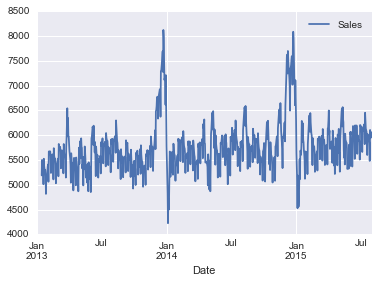

In [120]:
pd.rolling_mean(data[['Sales']], window=15, freq='D').plot()

> Identify the date with largest drop in sales from the same date in the previous month

In [181]:
average_daily_sales = data[['Sales', 'Open']].resample('D', how='mean')
average_daily_sales['DiffVsLastWeek'] = average_daily_sales[['Sales']].diff(periods=7)

average_daily_sales.sort_values(by='DiffVsLastWeek').head()

# Unsurprisingly, this day is Dec. 25 and Dec. 26 in 2014 and 2015. When the store is closed and there are many sales in the preceding week. How, about when the store is open?

average_daily_sales[average_daily_sales.Open == 1].sort_values(by='DiffVsLastWeek').head()

# The top values are Dec. 24 and then 2013-12-09 and 2013-10-14 where on average sales were 4k lower than the same day in the previous week.


,Sales,Open,DiffVsLastWeek
Date,,,
2013-12-24,4693.101345,1,-7014.515695
2014-12-24,4933.386096,1,-5209.272727
2013-12-09,6822.938117,1,-4811.537220
2013-10-14,5893.636771,1,-4027.798206
2015-04-20,5909.294170,1,-4023.443049


> Compute the total sales up until Dec. 2014

In [183]:
total_daily_sales = data[['Sales']].resample('D', how='sum')
pd.expanding_sum(total_daily_sales)['2014-12'].head(15)

pd.expanding_sum(data['Sales']['2014-12'], freq='D')

Date
2014-12-01     10991.412834
2014-12-02     20450.045989
2014-12-03     29282.151872
2014-12-04     38430.859893
2014-12-05     48914.128342
2014-12-06     55843.968984
2014-12-07     56054.096257
2014-12-08     63070.155080
2014-12-09     69839.918717
2014-12-10     76160.562567
2014-12-11     82745.529412
2014-12-12     89698.696257
2014-12-13     96949.205348
2014-12-14     97183.077005
2014-12-15    110159.955080
2014-12-16    121519.377540
2014-12-17    131662.036364
2014-12-18    142152.102674
2014-12-19    152332.304813
2014-12-20    160841.835294
2014-12-21    161119.105882
2014-12-22    172891.983957
2014-12-23    184348.801070
2014-12-24    189282.187166
2014-12-25    189448.375401
2014-12-26    189667.881283
2014-12-27    195775.145455
2014-12-28    196008.376471
2014-12-29    203806.693048
2014-12-30    212005.348663
2014-12-31    216171.756150
Freq: D, Name: Sales, dtype: float64

In [190]:
pd.rolling_mean(data['Sales'], window=15, freq='D').diff(1).head(40)

# Unsurprisingly, they occur at the beginning of every year after the holiday season.

Date
2013-01-01           NaN
2013-01-02           NaN
2013-01-03           NaN
2013-01-04           NaN
2013-01-05           NaN
2013-01-06           NaN
2013-01-07           NaN
2013-01-08           NaN
2013-01-09           NaN
2013-01-10           NaN
2013-01-11           NaN
2013-01-12           NaN
2013-01-13           NaN
2013-01-14           NaN
2013-01-15           NaN
2013-01-16    310.654572
2013-01-17    -93.468759
2013-01-18    -12.604484
2013-01-19    -37.594141
2013-01-20   -346.785830
2013-01-21    515.226906
2013-01-22   -149.868999
2013-01-23    -59.962571
2013-01-24    -18.341824
2013-01-25      1.752108
2013-01-26   -130.973752
2013-01-27   -351.249208
2013-01-28    342.878924
2013-01-29    -25.956353
2013-01-30     23.748161
2013-01-31    106.161256
2013-02-01    108.606457
2013-02-02     38.548939
2013-02-03   -349.095785
2013-02-04    608.792287
2013-02-05      4.814948
2013-02-06    -13.481973
2013-02-07    -18.922990
2013-02-08     31.613154
2013-02-09    -96.84